In [1]:
# Implementing the network structure from the paper https://arxiv.org/abs/1704.02019
# Associative Content Addressable Memory with Exponentially Many Robust Stable States
# By Rishidev Chaudhuri and Ila Fiete

In [2]:
# Seems to work nicely now!

# Added a draft cell to count the number of satisfied states

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pprint
import time
%matplotlib inline

import matplotlib.cm as cm # color maps

/Users/adammarblestone/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
global_num_timesteps = 1000

In [5]:
def matching_assignment(N, N_c, z, z_c):
    
    start = time.time()
    
    if N_c * z_c != N * z:
        print "MISMATCHED SIZES"

    outgoing_edges_left = []
    for i in range(N):
        for j in range(z):
            outgoing_edges_left.append((i,"?"))

    incoming_edges_right = []
    for k in range(N_c):
        for l in range(z_c):
            incoming_edges_right.append(("?", k))

    matches = []
    while len(matches) < N*z:
        random_index_left = np.random.randint(0, len(outgoing_edges_left), size=1)[0]
        random_index_right = np.random.randint(0, len(incoming_edges_right), size=1)[0]
        s = (outgoing_edges_left[random_index_left][0], incoming_edges_right[random_index_right][1])
        if not s in matches:
            matches.append(s)
            outgoing_edges_left.pop(random_index_left)
            incoming_edges_right.pop(random_index_right)
        if time.time() - start > 10: # This is to re-start if it doesn't find a good assignment on this round
            print "Trying another assignment..."
            return matching_assignment(N, N_c, z, z_c)
        
    input_to_constraint_node_connectivity = []
    for n in range(N):
        outgoing = []
        for o in matches:
            if o[0] == n:
                outgoing.append(o[1])
        input_to_constraint_node_connectivity.append(outgoing)
        
    return input_to_constraint_node_connectivity

N = 48
N_c = 20
z = 5
z_c_avg = 12
r = 8
M_typical = 16


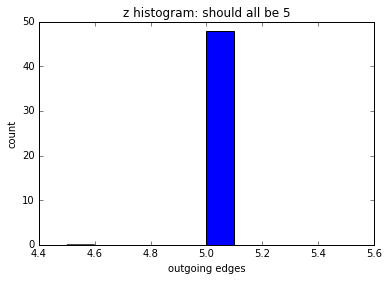


total outgoing edges
240


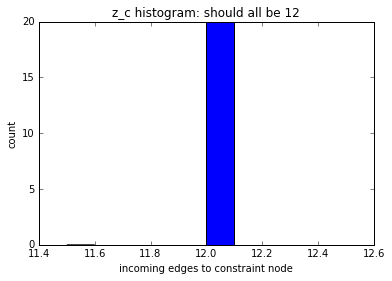


total incoming edges
240


In [6]:
# First define the input to constraint node connectivity

N = 48 # Should be a multiple of 12
print "N = %i" % N

N_c = int(5*N/12)
print "N_c = %i" % N_c

z = 5 # Should be 5
print "z = %i" % z

z_c_avg = int(N*z/N_c)
print "z_c_avg = %i" % z_c_avg

r = 8
print "r = %i" % r

M_typical = 2**(z_c_avg-r)
print "M_typical = %i" % M_typical

input_to_constraint_node_connectivity = matching_assignment(N, N_c, z, z_c_avg)
    
constraint_node_to_input_connectivity = []
for i in range(N_c):
    temp = []
    for j in range(N):
        if i in input_to_constraint_node_connectivity[j]:
            temp.append(j)
    constraint_node_to_input_connectivity.append(temp)
    
plt.figure()
plt.title("z histogram: should all be 5")
plt.xlabel("outgoing edges")
plt.ylabel("count")
plt.hist([len(q) for q in input_to_constraint_node_connectivity])
plt.show()

print "\ntotal outgoing edges"
print np.sum([len(q) for q in input_to_constraint_node_connectivity])

plt.figure()
plt.title("z_c histogram: should all be 12")
plt.xlabel("incoming edges to constraint node")
plt.ylabel("count")
plt.hist([len(q) for q in constraint_node_to_input_connectivity])
plt.show()

print "\ntotal incoming edges"
print np.sum([len(q) for q in constraint_node_to_input_connectivity])

Estimated number of stable states: 1.92593e-34


/Users/adammarblestone/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


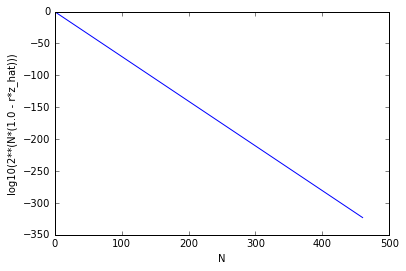

In [7]:
# Estimating the number of stable states: From equation 2 of the paper, requiring r*z/z_c <= 1 for exponential scaling
z_hat = float(z)/float(z_c_avg)
num_states = 2**(N*(1.0 - r*z_hat))
print "Estimated number of stable states: %g" % num_states

plt.figure()
plt.plot([np.log10(2**(Nprime*(1.0 - r*z_hat))) for Nprime in range(1000)])
plt.xlabel("N")
plt.ylabel("log10(2**(N*(1.0 - r*z_hat)))")
plt.show()

In [8]:
def generate_random_parity_states(input_size, num_parity_states_to_generate):
    parity_states = []
    for i in range(num_parity_states_to_generate):
        parity = 1
        state = []
        while parity == 1:
            state = np.random.randint(0,2,size = input_size)
            parity = sum(state) % 2
            if state in parity_states:
                parity = 1 # A hack to make sure all the permitted parity states in a node are distinct
            if parity == 0:
                parity_states.append(state)

    return parity_states

print generate_random_parity_states(12, 1)

[array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0])]


In [9]:
def M_for_constraint_node(constraint_node_index):
    z_c_for_this_node = len(constraint_node_to_input_connectivity[constraint_node_index])
    return 2**(z_c_for_this_node - r)

In [10]:
def generate_constraint_node_neurons(constraint_node_index):
    neurons = []
    z_c_for_this_node = len(constraint_node_to_input_connectivity[constraint_node_index])
    M_for_this_node = M_for_constraint_node(constraint_node_index)
    for i in range(M_for_this_node):
        neuron = {}
        neuron["inputs"] = constraint_node_to_input_connectivity[constraint_node_index]
        neuron["num_inputs"] = len(neuron["inputs"])
        neuron["preferred_parity_config"] = generate_random_parity_states(neuron["num_inputs"], 1)[0]
        neuron["ons_preferred"] = [neuron["inputs"][j] for j in range(neuron["num_inputs"]) if neuron["preferred_parity_config"][j] == 1] 
        neuron["offs_preffered"] = [neuron["inputs"][j] for j in range(neuron["num_inputs"]) if neuron["preferred_parity_config"][j] == 0]
        neuron["bias_term"] = neuron["num_inputs"] - np.sum(neuron["preferred_parity_config"])
        neurons.append(neuron)

    return neurons

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(generate_constraint_node_neurons(N_c-1)[0]) # Show what the first neuron in the last constraint node looks like

{   'bias_term': 4,
    'inputs': [2, 11, 13, 15, 18, 21, 28, 33, 36, 37, 38, 41],
    'num_inputs': 12,
    'offs_preffered': [18, 21, 33, 38],
    'ons_preferred': [2, 11, 13, 15, 28, 36, 37, 41],
    'preferred_parity_config': array([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1])}


In [11]:
def get_full_index(constraint_node_index, index_within_node):
    return N + sum([M_for_constraint_node(k) for k in range(constraint_node_index)]) + index_within_node

In [12]:
# Generating the full weight matrix and biases

last_constraint_node_index = N_c-1

last_neuron_in_last_constraint_node_index = M_for_constraint_node(last_constraint_node_index) - 1

total_number_neurons = get_full_index(last_constraint_node_index, last_neuron_in_last_constraint_node_index) + 1
total_number_neurons = int(total_number_neurons) # Not sure why it is making me do this
print "total number of neurons %i" % total_number_neurons
 
full_weight_matrix = np.array([[0 for j in range(total_number_neurons)] for i in range(total_number_neurons)], dtype = np.int32)

biases = np.array([0 for j in range(total_number_neurons)], dtype = np.int32)

constraint_node_preferred_states = []

for node in range(N_c): # Index over constraint nodes
    neurons_in_node = generate_constraint_node_neurons(node) # Generate neurons in that constraint node
    z_c_for_this_node = len(constraint_node_to_input_connectivity[node])
    M_for_this_node = M_for_constraint_node(node)
    this_node_preferred_states = []
    for m in range(M_for_this_node):
        neuron_full_index = get_full_index(node, m)
        neuron = neurons_in_node[m]
        for g in neuron["ons_preferred"]: # Constraint neuron to input neuron and vice versa
            full_weight_matrix[neuron_full_index][g] = 1
            full_weight_matrix[g][neuron_full_index] = 1
        for g in neuron["offs_preffered"]: # Constraint neuron to input neuron and vice versa
            full_weight_matrix[neuron_full_index][g] = -1
            full_weight_matrix[g][neuron_full_index] = -1
        for p in range(m, M_for_this_node): # Inhibitory internal connectivity within the same node
            p_full_index = get_full_index(node, p)
            if p != m:
                full_weight_matrix[neuron_full_index][p_full_index] = -1*(neuron["num_inputs"] - 1)
                full_weight_matrix[p_full_index][neuron_full_index] =  -1*(neuron["num_inputs"] - 1)
        biases[neuron_full_index] = neuron["bias_term"]
        this_node_preferred_states.append(zip(neuron["inputs"], np.ndarray.tolist(neuron["preferred_parity_config"])))
    constraint_node_preferred_states.append(this_node_preferred_states)

total number of neurons 368


In [13]:
# Trying to actually count stable states

#pp.pprint(constraint_node_preferred_states)

def intersection(list1, list2):
    return list(set(list1) & set(list2))

pairs = []

for k in range(N_c-1):
    states_first = constraint_node_preferred_states[k]
    states_second = constraint_node_preferred_states[k+1]
    
    input_overlap = intersection(generate_constraint_node_neurons(k)[0]["inputs"], generate_constraint_node_neurons(k+1)[0]["inputs"])
    
    pairs_from_k = []
    
    for f in range(len(states_first)):
        for s in range(len(states_second)):
            sect = intersection(states_first[f], states_second[s])
            if len(sect) == len(input_overlap): # For any shared input neurons, the neurons must assign the same 0/1 preference
                pairs_from_k.append(((k, f), (k+1, s)))
    
    pairs.append(pairs_from_k)
    
#pp.pprint(pairs)

def build_paths(k, edge):
    if k == len(pairs)-1:
        return 1
    else:
        s = 0
        for edge_outgoing in pairs[k+1]:
            if edge[1] == edge_outgoing[0]:
                s += build_paths(k+1, edge_outgoing)
        return s

count_paths = True
if count_paths:
    print "Counting paths..."
    total_full_paths = 0
    for edge in pairs[0]:
        total_full_paths += build_paths(0, edge)    
    print total_full_paths

Counting paths...
7440385536


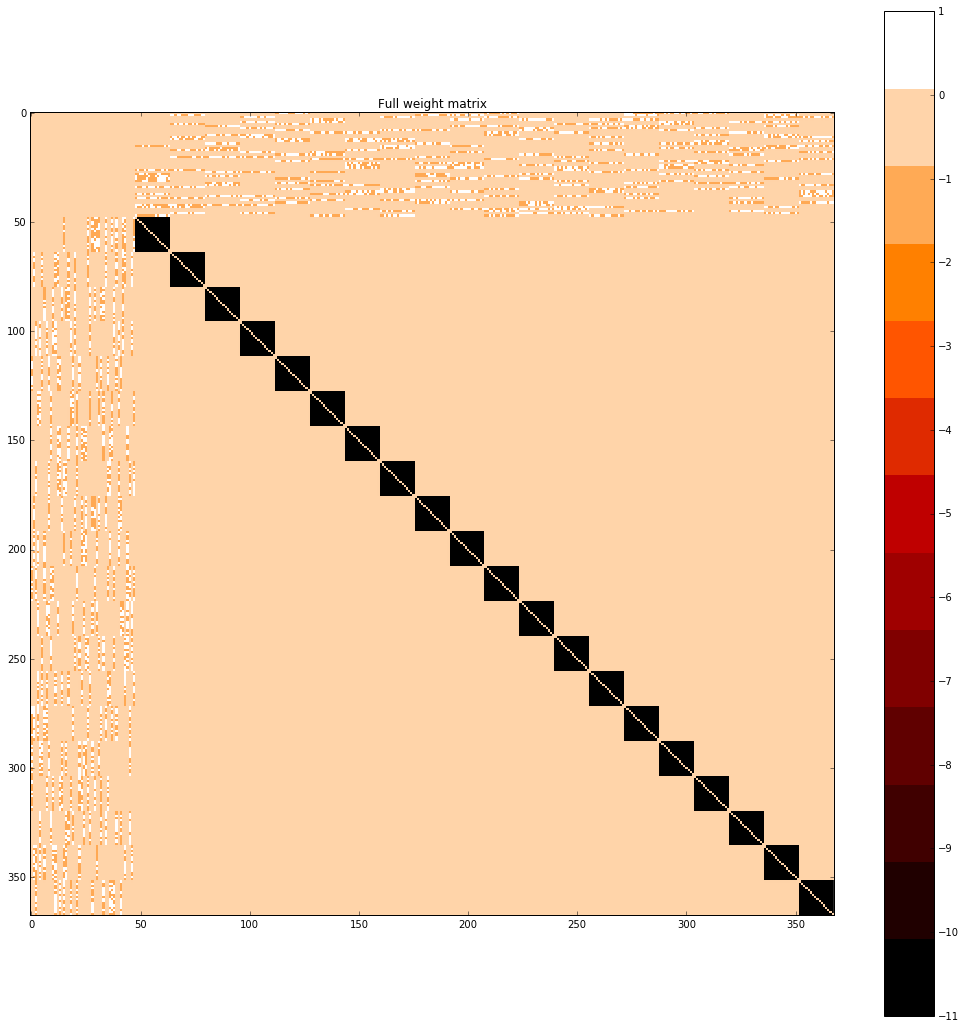

In [14]:
plt.rcParams['figure.figsize'] = (18, 18)
plt.figure()
plt.title("Full weight matrix")
cmap = cm.get_cmap('gist_heat', z_c_avg + 1)
plt.imshow(full_weight_matrix, cmap = cmap, interpolation='none')
plt.colorbar(ticks = np.arange(-1*z_c_avg, 2, 1))
plt.show()

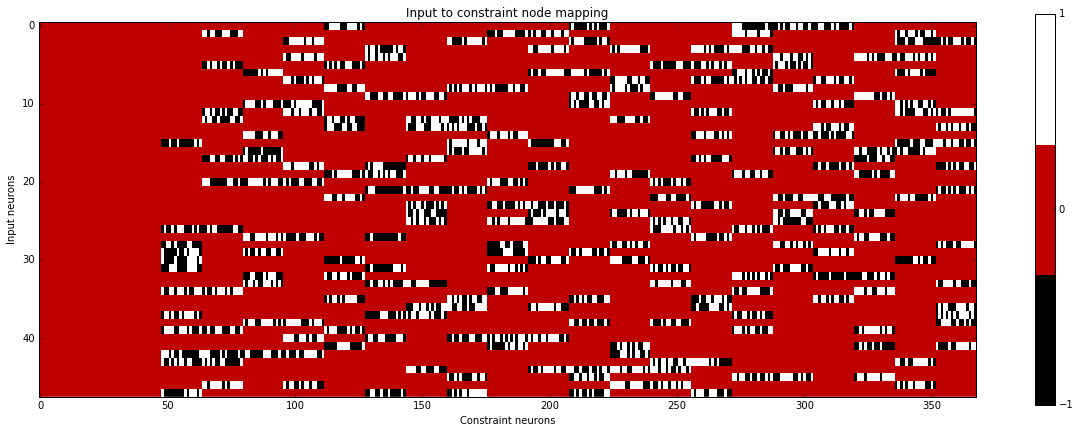

In [15]:
plt.rcParams['figure.figsize'] = (21, 7)
plt.figure()
plt.title("Input to constraint node mapping")
adj = full_weight_matrix[:N][:]
plt.ylabel("Input neurons")
plt.xlabel("Constraint neurons")
cmap = cm.get_cmap('gist_heat', 3)
plt.imshow(adj, interpolation='none', cmap = cmap, aspect = 0.4*float(total_number_neurons)/float(N))
plt.colorbar(ticks = [-1,0,1])

plt.show()

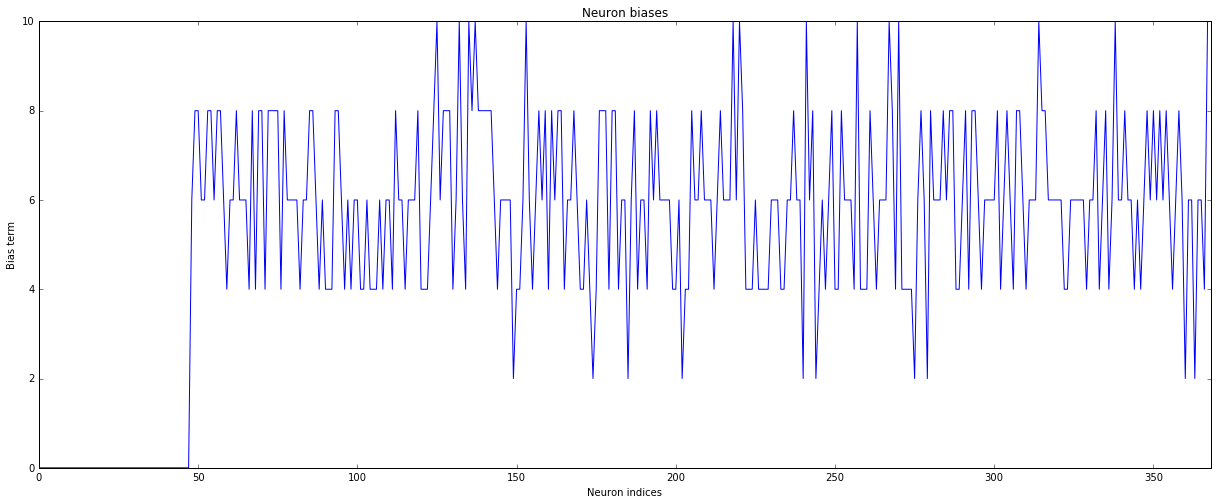

In [16]:
plt.rcParams['figure.figsize'] = (21, 8)
plt.figure()
plt.title("Neuron biases")
plt.xlabel("Neuron indices")
plt.xlim(0,total_number_neurons)
plt.ylabel("Bias term")
plt.plot(biases)
plt.show()

In [17]:
# Defining some Hopfield aspects

def random_state(num_neurons):
    return np.random.randint(0, 2, size = num_neurons)

def time_step(state, weight_matrix, biases): # Asynchronous mode

    x = state[:]
    
    k = np.random.randint(0, total_number_neurons, size=1)[0] # Pick a random single neuron to update
    
    a = 0
    
    for j in range(total_number_neurons):
        a += weight_matrix[k][j] * x[j]
        
    a += biases[k]
        
    ns = x
        
    if a > 0:
        ns[k] = 1
    elif a < 0:
        ns[k] = 0
    elif a == 0: # If the activation is exactly zero
        ns[k] = random.randint(0,1)
                        
    return np.array(ns, dtype = np.int32)

def energy(s, weights, bias):
        
    E = 0.5*np.dot(np.matmul(weights, s), s) + np.dot(s, bias)
        
    return -1*E

def small_perturbation(perturb_size, state):
    new_state = np.zeros(len(state))
    prob = float(perturb_size)/float(len(state))
    for i in range(len(state)):
        if np.random.rand() < prob:
            new_state[i] = (state[i] + 1) % 2
        else:
            new_state[i] = state[i]
    return np.array(new_state, dtype = np.int32)

energy 4937.000000 [0 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1
 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 1 1 1
 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1]
energy -154.000000 [0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1
 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]

___Recovery from Perturbation___
Percentage perturbed: 2.000000
energy -120.000000 [1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1
 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
energy -171.000000 [0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1
 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


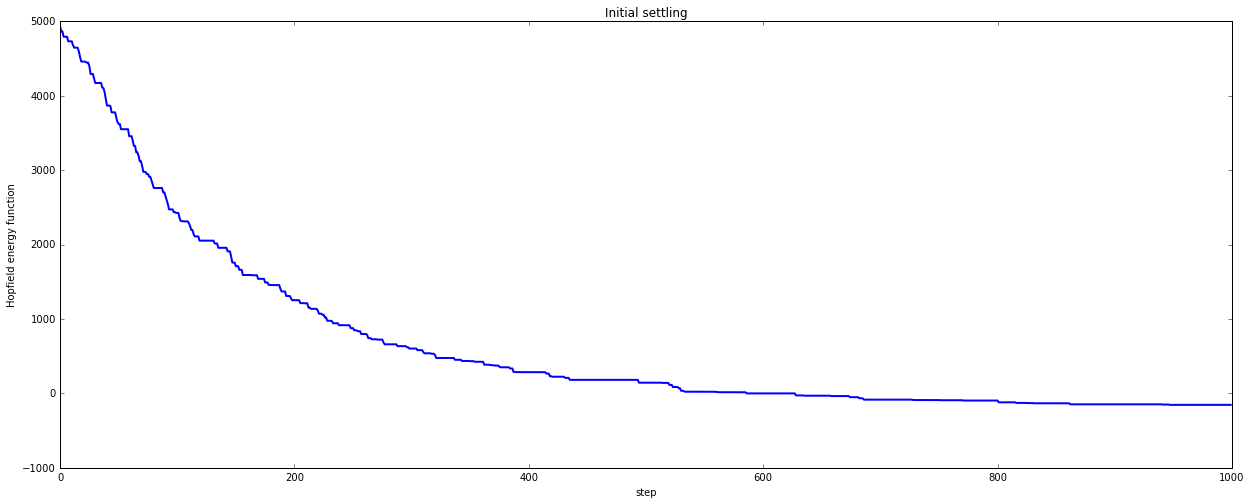

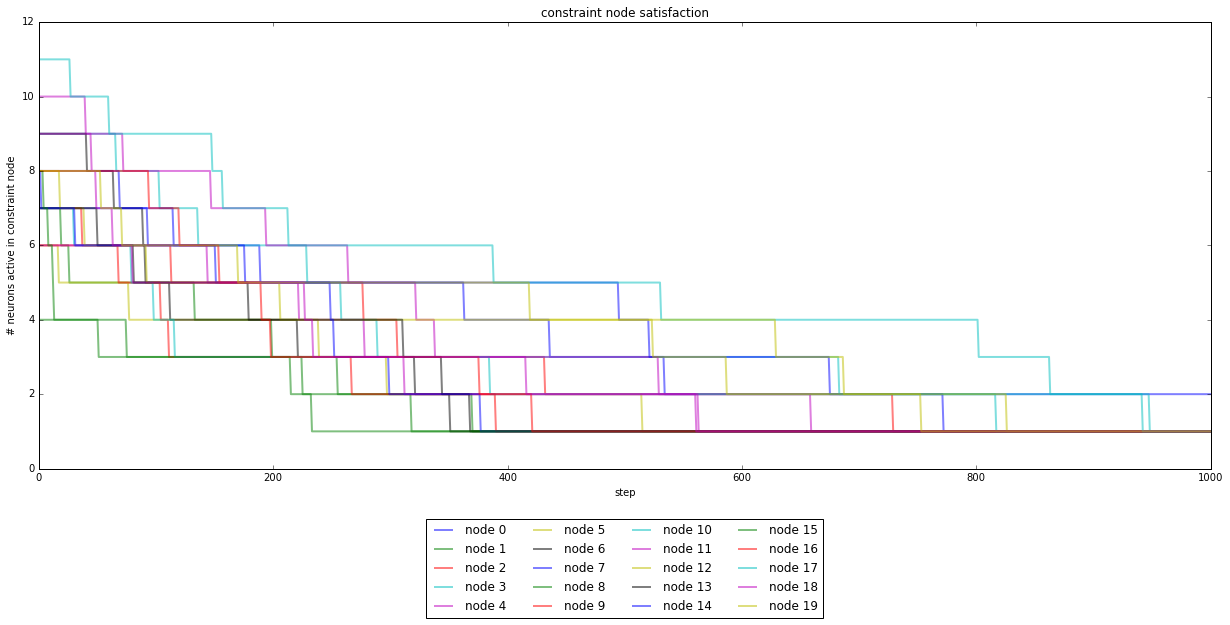

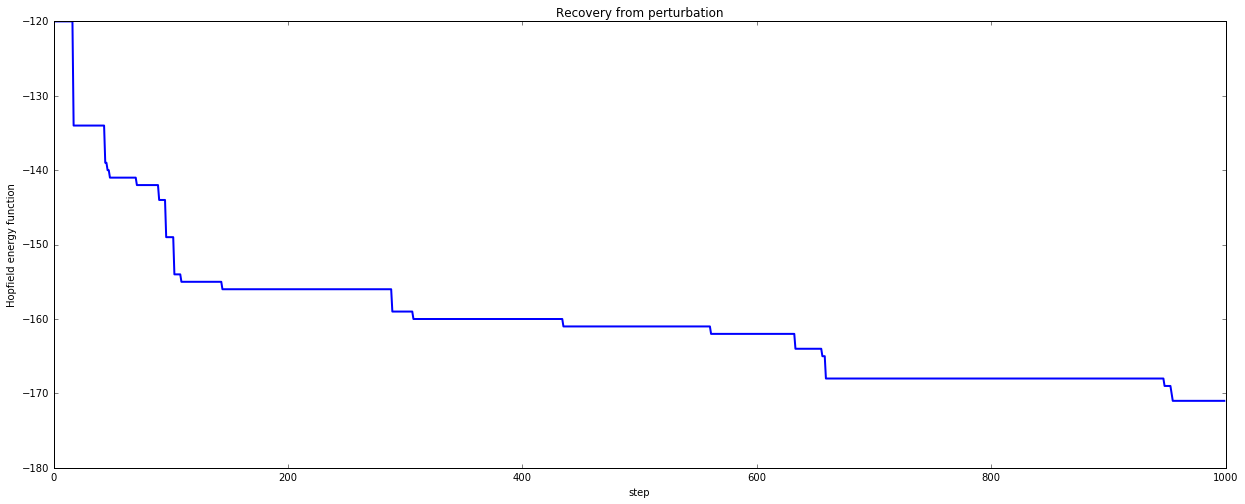

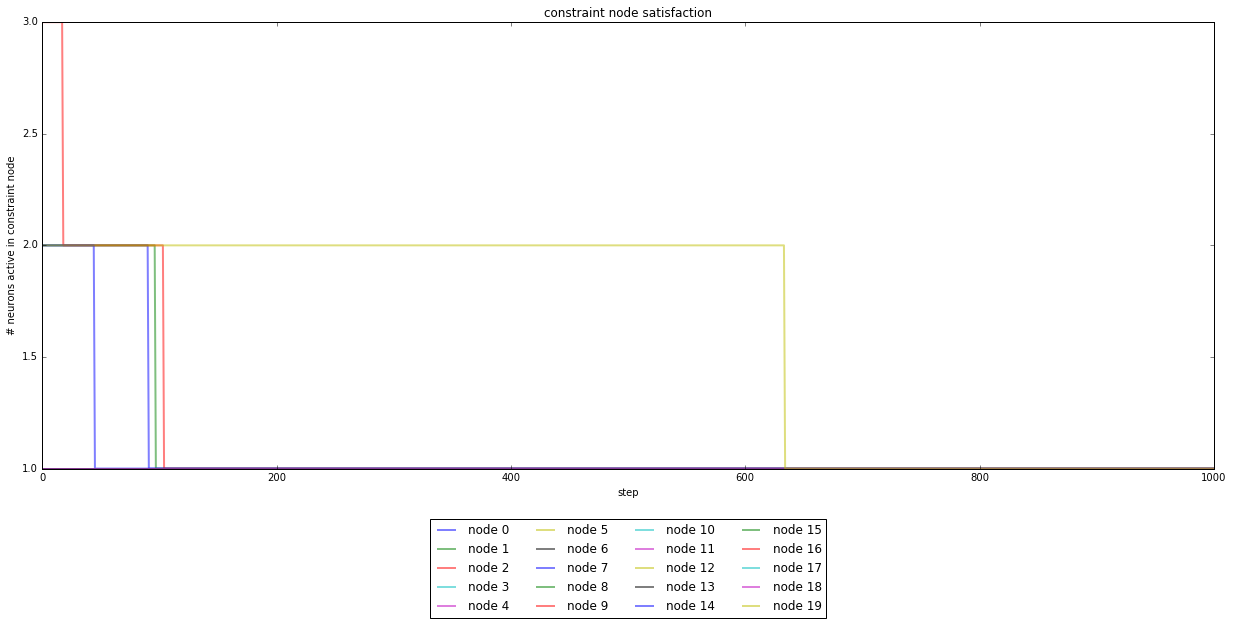

In [18]:
# Test out some Hopfield dynamics
initial_random_state = random_state(total_number_neurons)

num_timesteps = global_num_timesteps
state = np.array(initial_random_state, dtype = np.int32)
energies = []
e = energy(state, full_weight_matrix, biases)
print "energy %f" % e, state[:2*N]

constraint_node_satisfactions = []
sats = []
for p in range(N_c):
    M = M_for_constraint_node(p)
    ind1 = get_full_index(p, 0)
    ind2 = get_full_index(p, M-1)
    sats.append(np.sum(state[ind1:ind2+1]))
constraint_node_satisfactions.append(sats)

for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    state = new_state
    
    sats = []
    for p in range(N_c):
        M = M_for_constraint_node(p)
        ind1 = get_full_index(p, 0)
        ind2 = get_full_index(p, M-1)
        sats.append(np.sum(state[ind1:ind2+1]))
    constraint_node_satisfactions.append(sats)
    
    energies.append(e)
    
print "energy %f" % e, new_state[:2*N]

plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.title("Initial settling")
plt.plot(energies, linewidth = 2)

plt.figure()
plt.xlabel("step")
plt.ylabel("# neurons active in constraint node")
plt.title("constraint node satisfaction")
for p in range(N_c):
    plt.plot([c[p] for c in constraint_node_satisfactions], label = "node %i" %p, linewidth = 2, alpha = 0.5)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=4)

print "\n___Recovery from Perturbation___"
perturb_percent = 2.0
print "Percentage perturbed: %f" % perturb_percent
perturbed_state = small_perturbation(perturb_percent * total_number_neurons / 100.0, state)
num_timesteps = global_num_timesteps
state = perturbed_state
energies = []
e = energy(state, full_weight_matrix, biases)

constraint_node_satisfactions = []
sats = []
for p in range(N_c):
    M = M_for_constraint_node(p)
    ind1 = get_full_index(p, 0)
    ind2 = get_full_index(p, M-1)
    sats.append(np.sum(state[ind1:ind2+1]))
constraint_node_satisfactions.append(sats)

print "energy %f" % e, state[:2*N]
for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    state = new_state
    
    sats = []
    for p in range(N_c):
        M = M_for_constraint_node(p)
        ind1 = get_full_index(p, 0)
        ind2 = get_full_index(p, M-1)
        sats.append(np.sum(state[ind1:ind2+1]))
    constraint_node_satisfactions.append(sats)
        
    energies.append(e)
    
print "energy %f" % e, new_state[:2*N]

plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.title("Recovery from perturbation")
plt.plot(energies, linewidth = 2)

plt.figure()
plt.xlabel("step")
plt.ylabel("# neurons active in constraint node")
plt.title("constraint node satisfaction")
for p in range(N_c):
    plt.plot([c[p] for c in constraint_node_satisfactions], label = "node %i" %p, linewidth = 2, alpha = 0.5)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=4)

energy -120.000000 [0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0
 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
energy -165.000000 [1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1
 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]

___Recovery from Perturbation___
Percentage perturbed: 2.000000
energy -113.000000 [1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1
 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
energy -175.000000 [1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1
 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


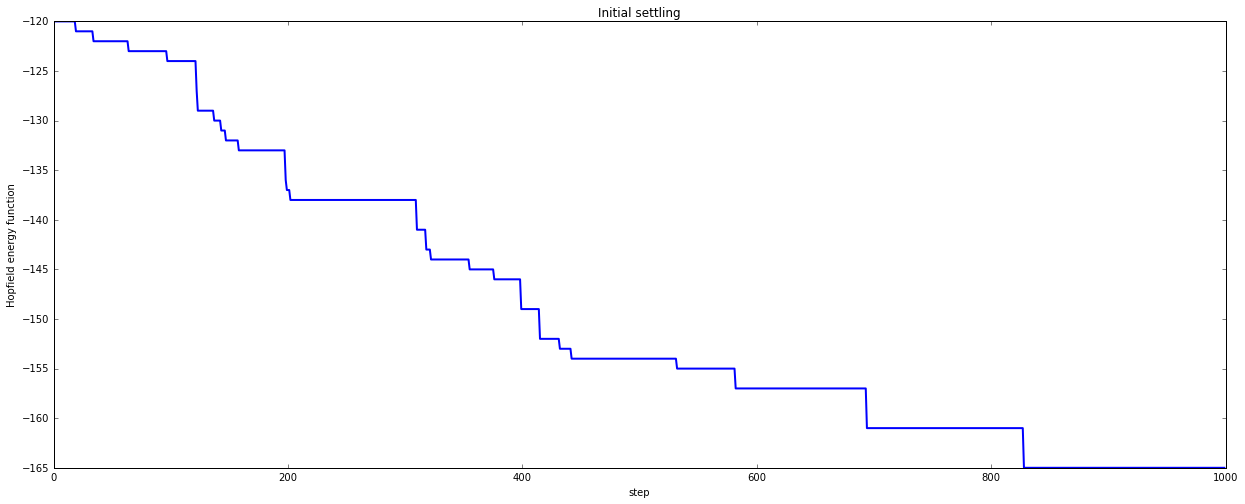

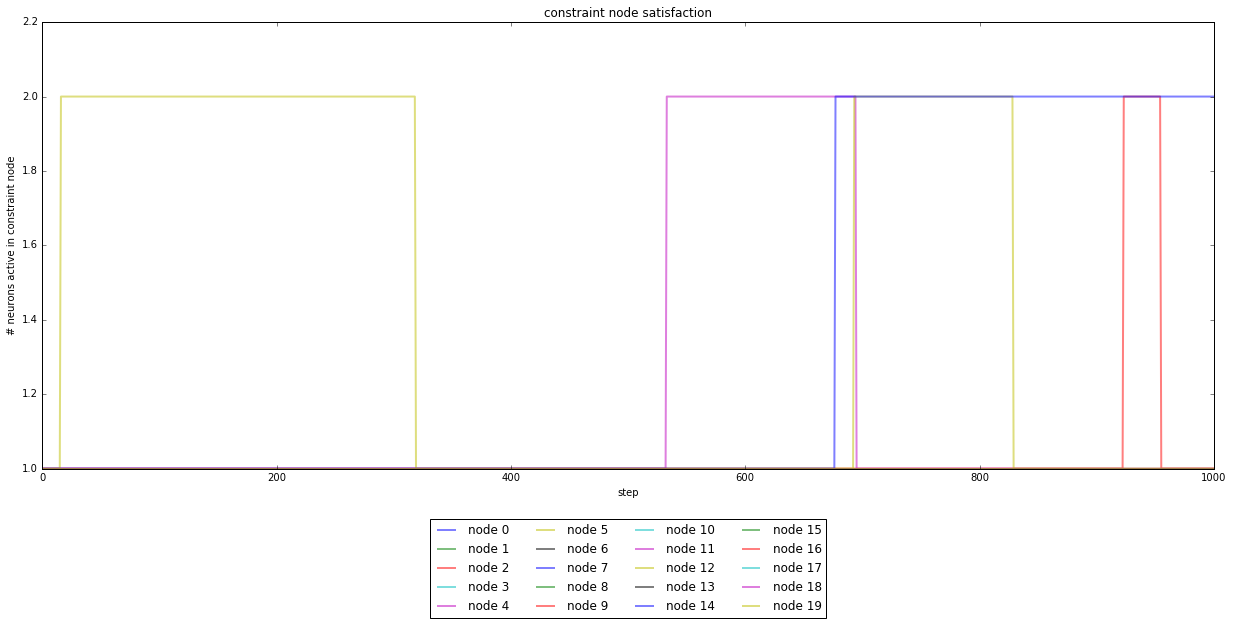

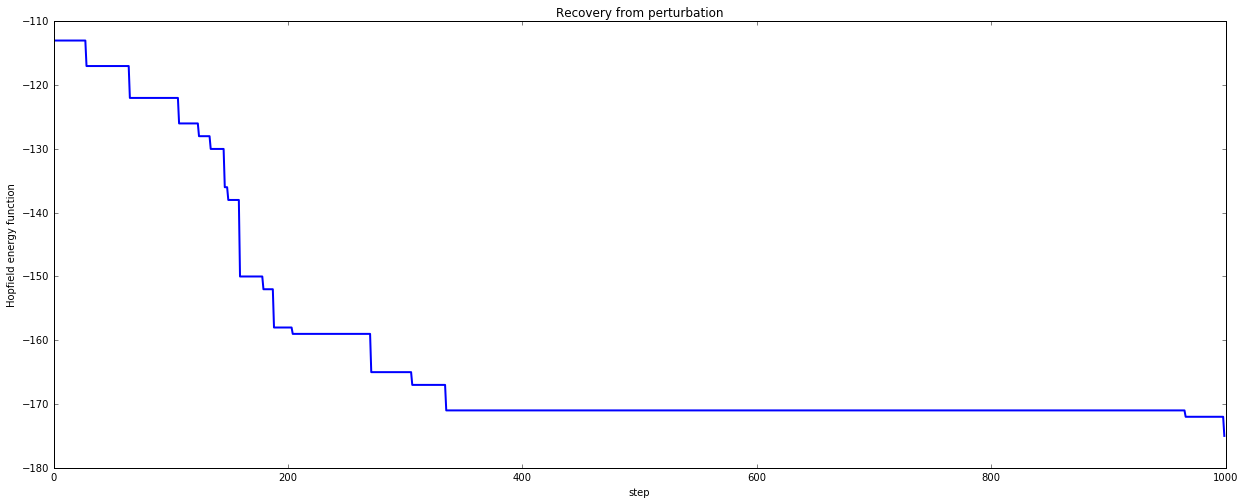

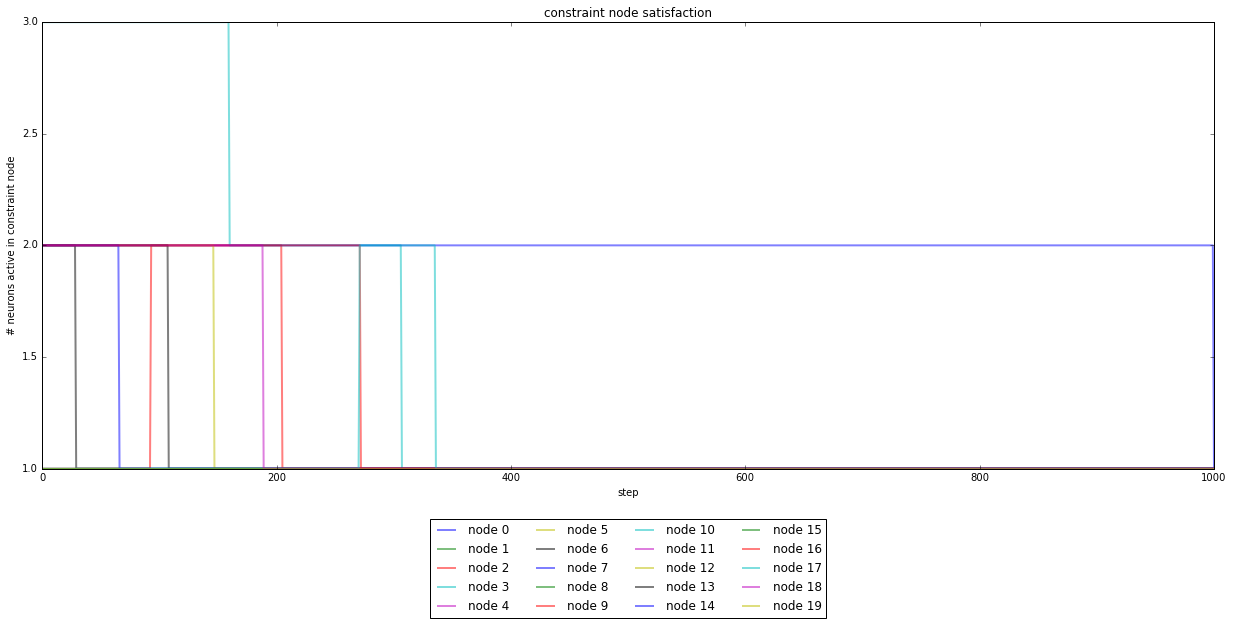

In [19]:
initial_nonrandom_state = np.ndarray.tolist(random_state(N)) # Visible nodes random
initial_nonrandom_state.extend([0 for j in range(total_number_neurons - N)])
for node in range(N_c): # Set just one neuron in each constraint node to be 1
    M_for_this_node = M_for_constraint_node(node)
    m = np.random.randint(0,M_for_this_node)
    neuron_full_index = get_full_index(node, m)
    initial_nonrandom_state[neuron_full_index] = 1
    
num_timesteps = global_num_timesteps
state = np.array(initial_nonrandom_state, dtype = np.int32)
energies = []
e = energy(state, full_weight_matrix, biases)
print "energy %f" % e, state[:2*N]

constraint_node_satisfactions = []
sats = []
for p in range(N_c):
    M = M_for_constraint_node(p)
    ind1 = get_full_index(p, 0)
    ind2 = get_full_index(p, M-1)
    sats.append(np.sum(state[ind1:ind2+1]))
constraint_node_satisfactions.append(sats)

for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    state = new_state
    
    sats = []
    for p in range(N_c):
        M = M_for_constraint_node(p)
        ind1 = get_full_index(p, 0)
        ind2 = get_full_index(p, M-1)
        sats.append(np.sum(state[ind1:ind2+1]))
    constraint_node_satisfactions.append(sats)
    
    energies.append(e)

print "energy %f" % e, new_state[:2*N]

plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.title("Initial settling")
plt.plot(energies, linewidth = 2)

plt.figure()
plt.xlabel("step")
plt.ylabel("# neurons active in constraint node")
plt.title("constraint node satisfaction")
for p in range(N_c):
    plt.plot([c[p] for c in constraint_node_satisfactions], label = "node %i" %p, linewidth = 2, alpha = 0.5)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=4)

print "\n___Recovery from Perturbation___"
perturb_percent = 2.0
print "Percentage perturbed: %f" % perturb_percent
perturbed_state = small_perturbation(perturb_percent * total_number_neurons / 100.0, state)
num_timesteps = global_num_timesteps
state = perturbed_state
energies = []
e = energy(state, full_weight_matrix, biases)
print "energy %f" % e, state[:2*N]

constraint_node_satisfactions = []
sats = []
for p in range(N_c):
    M = M_for_constraint_node(p)
    ind1 = get_full_index(p, 0)
    ind2 = get_full_index(p, M-1)
    sats.append(np.sum(state[ind1:ind2+1]))
constraint_node_satisfactions.append(sats)

for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    state = new_state
    
    sats = []
    for p in range(N_c):
        M = M_for_constraint_node(p)
        ind1 = get_full_index(p, 0)
        ind2 = get_full_index(p, M-1)
        sats.append(np.sum(state[ind1:ind2+1]))
    constraint_node_satisfactions.append(sats)
        
    energies.append(e)
    
print "energy %f" % e, new_state[:2*N]

plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.title("Recovery from perturbation")
plt.plot(energies, linewidth = 2)

plt.figure()
plt.xlabel("step")
plt.ylabel("# neurons active in constraint node")
plt.title("constraint node satisfaction")
for p in range(N_c):
    plt.plot([c[p] for c in constraint_node_satisfactions], label = "node %i" %p, linewidth = 2, alpha = 0.5)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=4)

energy -112.000000 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
energy -159.000000 [0 1 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1
 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]

___Recovery from Perturbation___
Percentage perturbed: 2.000000
energy -88.000000 [0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 1 0 1
 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
energy -161.000000 [0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1
 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


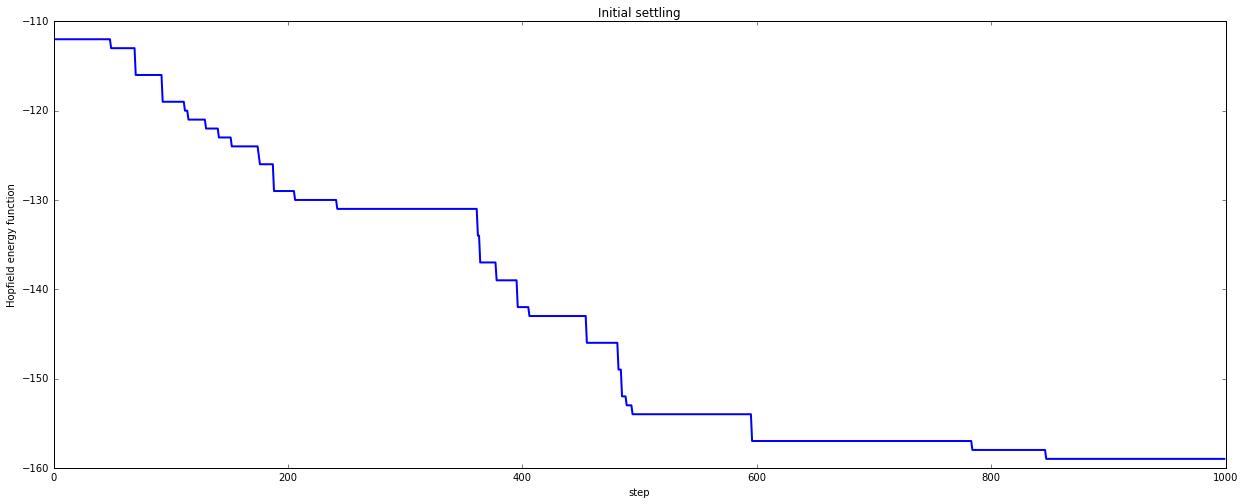

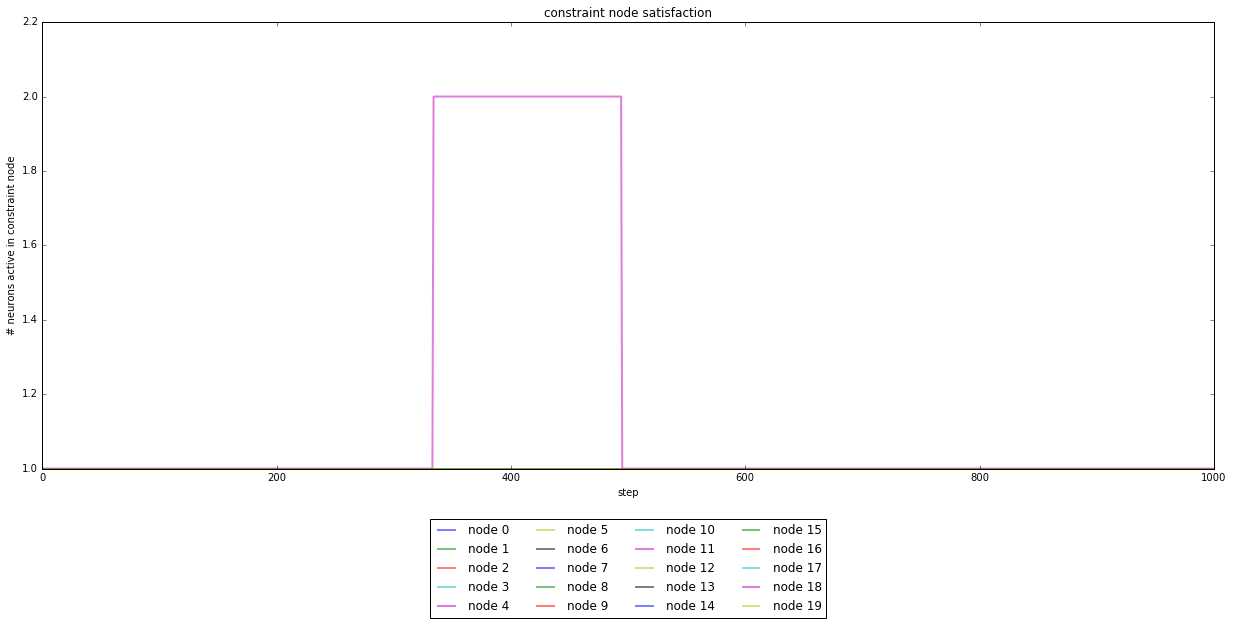

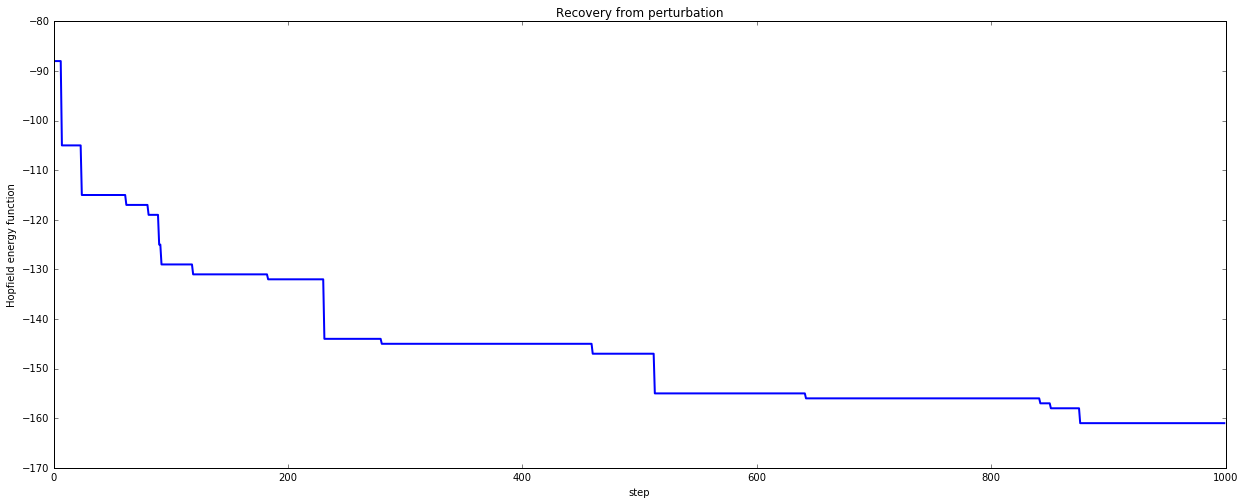

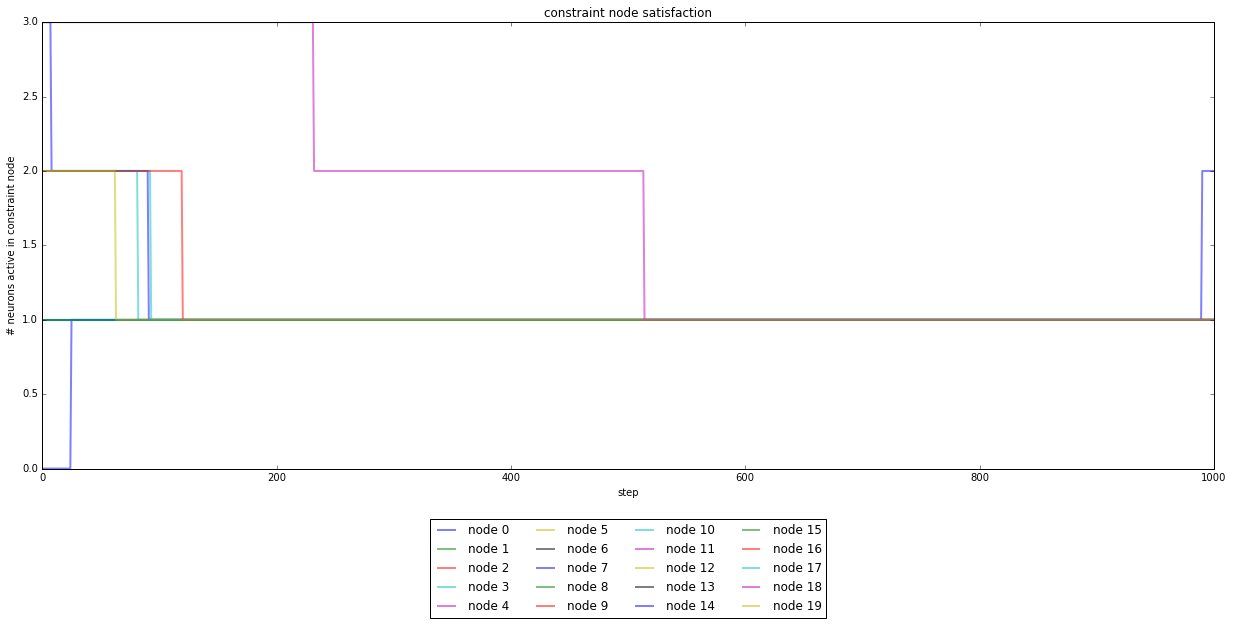

In [20]:
initial_nonrandom_state = np.ndarray.tolist(np.zeros(N)) # Visible nodes zero
initial_nonrandom_state.extend([0 for j in range(total_number_neurons - N)])
for node in range(N_c): # Set just one neuron in each constraint node to be 1
    M_for_this_node = M_for_constraint_node(node)
    m = np.random.randint(0,M_for_this_node)
    neuron_full_index = get_full_index(node, m)
    initial_nonrandom_state[neuron_full_index] = 1
    
num_timesteps = global_num_timesteps
state = np.array(initial_nonrandom_state, dtype = np.int32)
energies = []
e = energy(state, full_weight_matrix, biases)
print "energy %f" % e, state[:2*N]

constraint_node_satisfactions = []
sats = []
for p in range(N_c):
    M = M_for_constraint_node(p)
    ind1 = get_full_index(p, 0)
    ind2 = get_full_index(p, M-1)
    sats.append(np.sum(state[ind1:ind2+1]))
constraint_node_satisfactions.append(sats)

for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    energies.append(e)
    state = new_state
    
    sats = []
    for p in range(N_c):
        M = M_for_constraint_node(p)
        ind1 = get_full_index(p, 0)
        ind2 = get_full_index(p, M-1)
        sats.append(np.sum(state[ind1:ind2+1]))
    constraint_node_satisfactions.append(sats)
    
print "energy %f" % e, new_state[:2*N]

plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.title("Initial settling")
plt.plot(energies, linewidth = 2)

plt.figure()
plt.xlabel("step")
plt.ylabel("# neurons active in constraint node")
plt.title("constraint node satisfaction")
for p in range(N_c):
    plt.plot([c[p] for c in constraint_node_satisfactions], label = "node %i" %p, linewidth = 2, alpha = 0.5)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=4)

print "\n___Recovery from Perturbation___"
perturb_percent = 2.0
print "Percentage perturbed: %f" % perturb_percent
perturbed_state = small_perturbation(perturb_percent * total_number_neurons / 100.0, state)
num_timesteps = global_num_timesteps
state = perturbed_state
energies = []
e = energy(state, full_weight_matrix, biases)
print "energy %f" % e, state[:2*N]

constraint_node_satisfactions = []
sats = []
for p in range(N_c):
    M = M_for_constraint_node(p)
    ind1 = get_full_index(p, 0)
    ind2 = get_full_index(p, M-1)
    sats.append(np.sum(state[ind1:ind2+1]))
constraint_node_satisfactions.append(sats)

for i in range(num_timesteps):
    new_state = time_step(state, full_weight_matrix, biases)
    e = energy(new_state, full_weight_matrix, biases)
    energies.append(e)
    state = new_state
    
    sats = []
    for p in range(N_c):
        M = M_for_constraint_node(p)
        ind1 = get_full_index(p, 0)
        ind2 = get_full_index(p, M-1)
        sats.append(np.sum(state[ind1:ind2+1]))
    constraint_node_satisfactions.append(sats)
    
print "energy %f" % e, new_state[:2*N]

plt.figure()
plt.xlabel("step")
plt.ylabel("Hopfield energy function")
plt.title("Recovery from perturbation")
plt.plot(energies, linewidth = 2)

plt.figure()
plt.xlabel("step")
plt.ylabel("# neurons active in constraint node")
plt.title("constraint node satisfaction")
for p in range(N_c):
    plt.plot([c[p] for c in constraint_node_satisfactions], label = "node %i" %p, linewidth = 2, alpha = 0.5)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=4)